<a href="https://colab.research.google.com/github/Unfeir/DS/blob/main/Hw_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [10]:
df = pd.read_csv('/content/drive/MyDrive/Data sets/bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

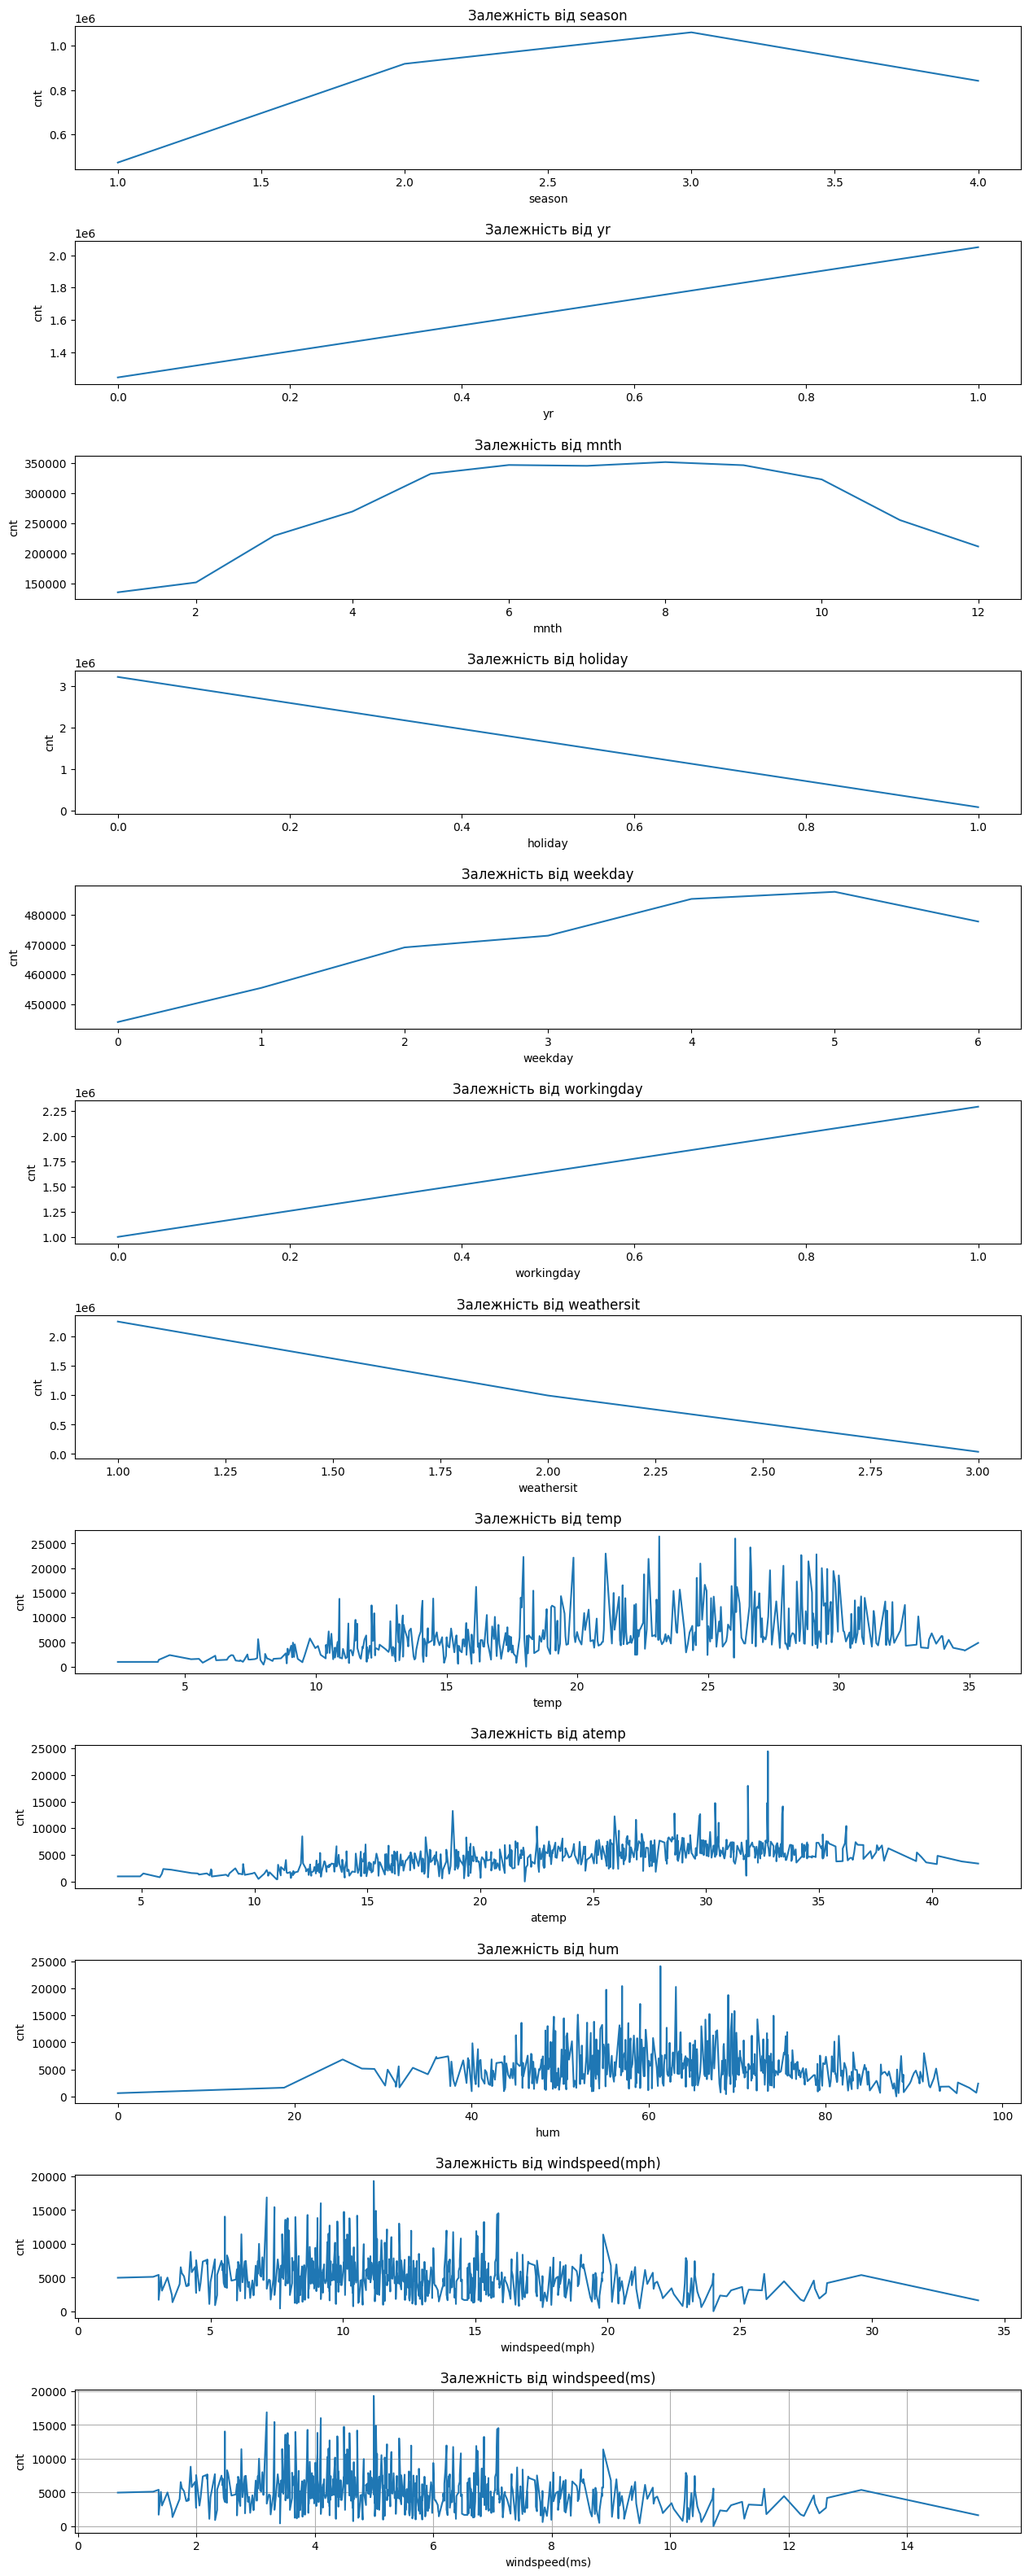

In [12]:
f = plt.figure(figsize=(15, 40))
f.subplots_adjust(hspace=0.5)
x = len(df.columns) - 1
count = 1
for column in df.columns[:-1]:

    f.add_subplot(x, 1, count)
    group_by = df.groupby(column).agg('sum')['cnt']
    group_by.plot()
    plt.ylabel('cnt')
    plt.xlabel(column)
    plt.title(f'Залежність від {column}')
    count += 1

plt.grid()

__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
  
  **Відповідь:** Можемо спостерігати рост попиту на прокат в літні місяці
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно
  
  **Відповідь:** weathersit, workingday, holiday, yr

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [13]:
pirson_correlations = df.iloc[:, :-1].corrwith(df.iloc[:, -1])
pirson_correlations

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [14]:
subset = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']]
correlations = subset.corr()
correlations

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [15]:
print(df.mean())


season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему.

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [16]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [17]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [18]:
from sklearn.linear_model import LinearRegression

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [19]:
reg = LinearRegression()
reg.fit(X, y)

for feature, weight in list(zip(df.columns, reg.coef_)):
    print(f"{feature=}, {weight=}")

feature='season', weight=570.8637960129914
feature='yr', weight=1021.9653779400622
feature='mnth', weight=-141.3017451148728
feature='holiday', weight=-86.7593446245368
feature='weekday', weight=137.22506441350538
feature='workingday', weight=56.391881775973005
feature='weathersit', weight=-330.2264620440312
feature='temp', weight=367.48373260182126
feature='atemp', weight=585.5493861188597
feature='hum', weight=-145.61430569885857
feature='windspeed(mph)', weight=12457138390688.885
feature='windspeed(ms)', weight=-12457138390887.346


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [20]:
from sklearn.linear_model import Lasso

lasso_regressor = Lasso()
lasso_regressor.fit(X, y)


for feature, weight in list(zip(df.columns, lasso_regressor.coef_)):
  print(f"{feature=}, {weight=}")


feature='season', weight=560.2416160308861
feature='yr', weight=1019.4634940657196
feature='mnth', weight=-128.73062703678696
feature='holiday', weight=-86.15278133371106
feature='weekday', weight=137.34789390496314
feature='workingday', weight=55.21237064135668
feature='weathersit', weight=-332.3698569623487
feature='temp', weight=376.3632362096943
feature='atemp', weight=576.530793504555
feature='hum', weight=-144.12915500348583
feature='windspeed(mph)', weight=-197.1396894024843
feature='windspeed(ms)', weight=-2.8051404183533485e-08


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [21]:
from sklearn.linear_model import Ridge

ridge_regressor = Ridge()
ridge_regressor.fit(X, y)
ridge_weights = list(zip(df.columns, ridge_regressor.coef_))


for feature, weight in list(zip(df.columns, ridge_regressor.coef_)):
    print(f"{feature=}, {weight=}")

feature='season', weight=563.0645722520181
feature='yr', weight=1018.9483787875305
feature='mnth', weight=-131.87332028247715
feature='holiday', weight=-86.74609799709232
feature='weekday', weight=138.00511117871918
feature='workingday', weight=55.90311037506467
feature='weathersit', weight=-332.34978849907367
feature='temp', weight=386.45788919190807
feature='atemp', weight=566.3470470600669
feature='hum', weight=-145.07132729867195
feature='windspeed(mph)', weight=-99.25944108179067
feature='windspeed(ms)', weight=-99.25944115434177


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [22]:
alphas = np.arange(1, 500, 50)

coefs_lasso = list()
coefs_ridge = list()

for alpha in alphas:
    # Обучение регрессора Lasso
    lasso_regressor = Lasso(alpha=alpha)
    lasso_regressor.fit(X, y)
    coefs_lasso.append(lasso_regressor.coef_)

    # Обучение регрессора Ridge
    ridge_regressor = Ridge(alpha=alpha)
    ridge_regressor.fit(X, y)
    coefs_ridge.append(ridge_regressor.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)
coefs_lasso, coefs_ridge

(array([[ 5.60241616e+02,  1.01946349e+03, -1.28730627e+02,
         -8.61527813e+01,  1.37347894e+02,  5.52123706e+01,
         -3.32369857e+02,  3.76363236e+02,  5.76530794e+02,
         -1.44129155e+02, -1.97139689e+02, -2.80514042e-08],
        [ 4.10969632e+02,  9.77019409e+02, -0.00000000e+00,
         -5.34489688e+01,  9.19434374e+01,  1.75372118e+01,
         -3.18125568e+02,  3.22829934e+02,  6.10031512e+02,
         -9.10689615e+01, -1.45066095e+02, -2.29892889e-08],
        [ 3.70077089e+02,  9.35945490e+02,  0.00000000e+00,
         -1.21619360e+01,  4.88886342e+01,  0.00000000e+00,
         -3.08805664e+02,  2.69417263e+02,  6.32502623e+02,
         -2.75042876e+01, -9.37749037e+01, -2.41657943e-08],
        [ 3.32835717e+02,  8.91870058e+02,  0.00000000e+00,
         -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -2.79616688e+02,  2.11052030e+02,  6.62920880e+02,
         -0.00000000e+00, -5.01551472e+01, -2.62789872e-08],
        [ 2.98134448e+02,  8.4565285

Проанализируйте динамику весов при увеличении параметра регуляризации:

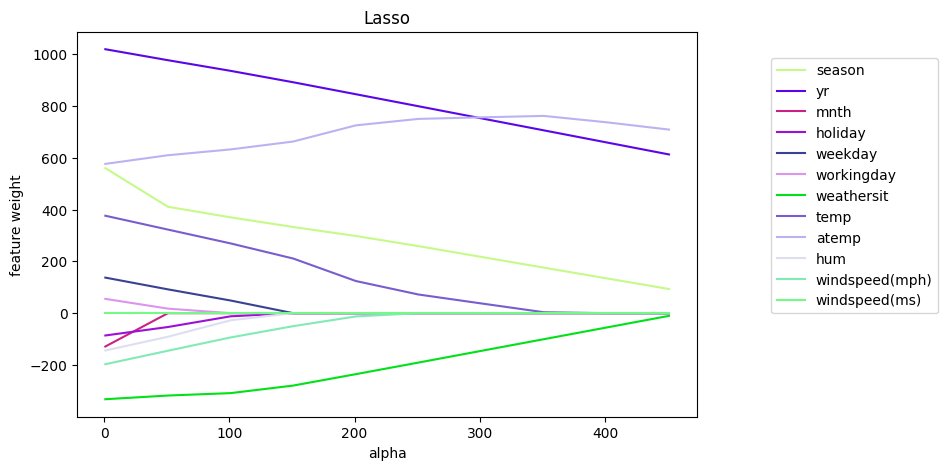

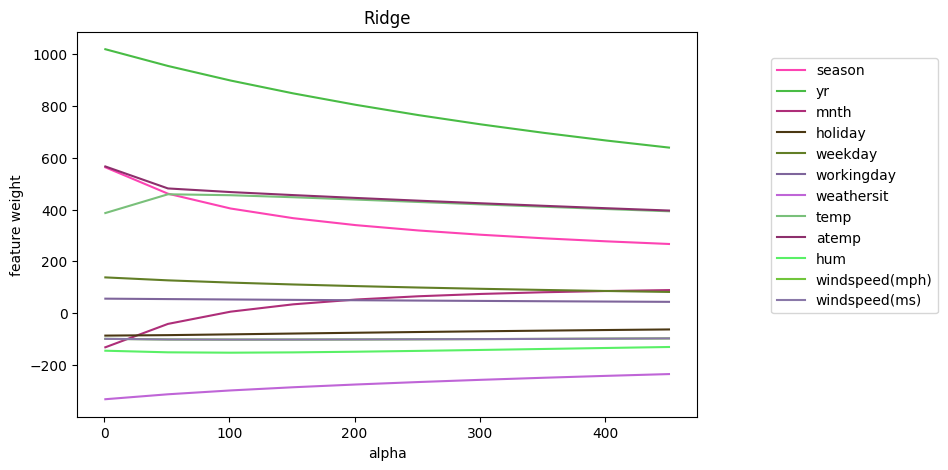

In [23]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?

  **Відповідь:** Lasso
2. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.

  **Відповідь:** Чим більше стає альфа - тим менше стають ваги. Він збільшує штраф, тим самами змушуючи модель мінімізувати ваги.
3. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.

  **Відповідь:** так, можно стверджувати що при `alpha > 0` маємо виключення. Ridge надає меншій вагі признакам з низьким впливом, значення коефіцієнтів знижуються, але не точно до нуля, навіть при невеликих значеннях.
4. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

  **Відповідь:** Lasso робить це швидше

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку.

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

In [34]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

In [47]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=3).fit(X, y)

In [41]:
for attribute, coefficient in list(zip(df_shuffled.columns[:-1], regressor.coef_)):
  print(f"{attribute=}, {coefficient=}")

attribute='season', coefficient=532.0189828413535
attribute='yr', coefficient=1015.0602226430595
attribute='mnth', coefficient=-100.03952614356629
attribute='holiday', coefficient=-83.29395987529904
attribute='weekday', coefficient=132.50446549095795
attribute='workingday', coefficient=51.557085614073735
attribute='weathersit', coefficient=-330.5598567399817
attribute='temp', coefficient=370.67985503003405
attribute='atemp', coefficient=581.396931065498
attribute='hum', coefficient=-140.00740550068844
attribute='windspeed(mph)', coefficient=-191.77140847135036
attribute='windspeed(ms)', coefficient=-2.6854702314758792e-08


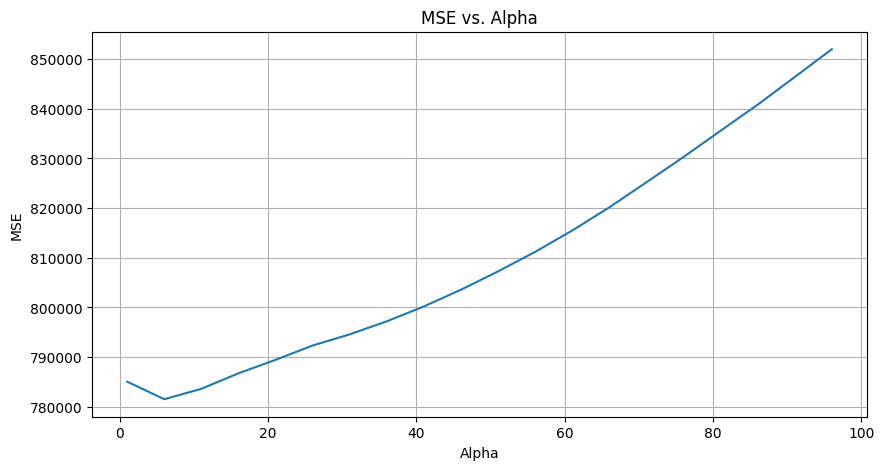

In [58]:
alpha_values = regressor.alphas_
mse_values = regressor.mse_path_.mean(axis=1)

plt.figure(figsize=(10, 5))
plt.plot(regressor.alphas_, regressor.mse_path_.mean(axis=1))
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.title('MSE vs. Alpha')
plt.grid(True)
plt.show()



Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


For 1 = 6
For 2 = 1
For 3 = 51


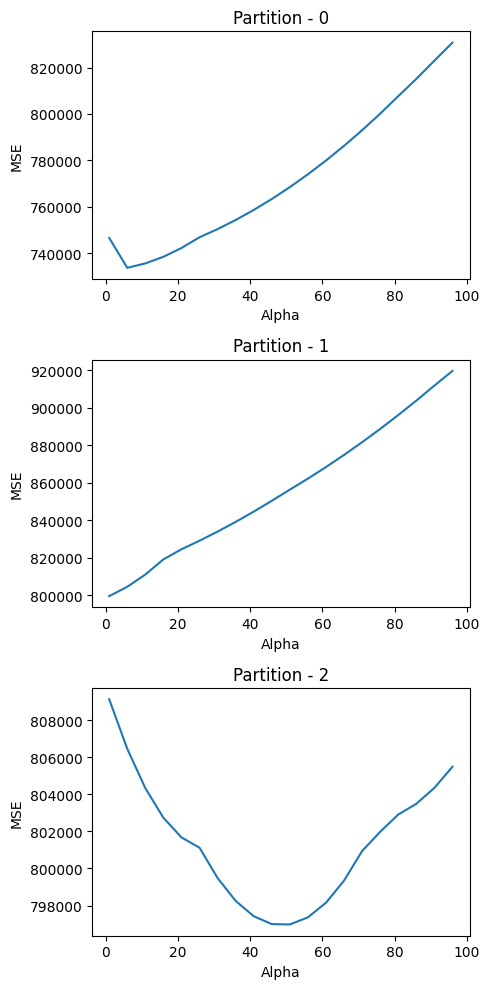

In [62]:

mi = np.argmin(regressor.mse_path_, axis=0)

for idx, ma in enumerate(regressor.alphas_[mi], start=1):
    print(f"For {idx} = {ma}")


fig, axs = plt.subplots(3, 1, figsize=(5, 10))

for idx, i in enumerate(axs):
    i.plot(regressor.alphas_, regressor.mse_path_[:, idx])
    i.set_xlabel('Alpha')
    i.set_ylabel('MSE')
    i.set_title(f'Partition - {idx}')

plt.tight_layout()
plt.show()

На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки.

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды?

__Ответ:__

In [86]:


largest = sorted([(name, coef) for name, coef in zip(df.columns[:-1], regressor.coef_)], key=lambda x: x[1])[-4:]

# print(largest)
for i in largest:
    print(i[0], '=', i[1])

temp = 370.67985503003405
season = 532.0189828413535
atemp = 581.396931065498
yr = 1015.0602226430595


так, це досить логічне ствердження

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

In [90]:
largest_3 = sorted([(name, coef) for name, coef in zip(df.columns[:-1], regressor.coef_)], key=lambda x: x[1])[:3]

# print(largest_3)
for i in largest_3:
    print(i[0], '=', i[1])

weathersit = -330.5598567399817
windspeed(mph) = -191.77140847135036
hum = -140.00740550068844


так, погана погода негативно впливає на популярніть прокату

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

In [94]:
largest_all = [(name, coef) for name, coef in zip(df.columns[:-1], regressor.coef_)]
largest_z = [(key, value) for key, value in largest_all if abs(value) < 1e-3]
print(largest_z)

[('windspeed(ms)', -2.6854702314758792e-08)]


швідкість вітру впливає на популярність прокату, але саме цей показник був виключений, бо існує такий самий показник, тільки в інших метриках
*windspeed(mph)*



### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации.

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.